# Hough Transform: Detecting Line Segments

In [1]:
#Import libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt


## Canny Edge Detection

Text(0.5, 1.0, 'P = 30% Threshold image')

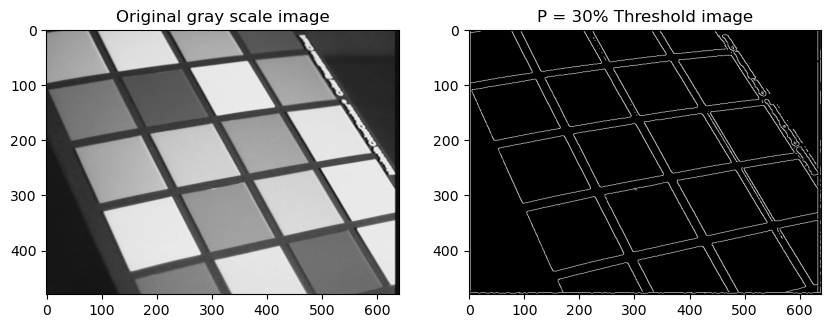

In [3]:
# Convolution
def convolve2d(image, kernel):
  kernel = np.flipud(np.fliplr(kernel))

  k_sizeX, k_sizeY = kernel.shape
  im_sizeX, im_sizeY = image.shape

  #output image (convolved with image)
  output = np.zeros((im_sizeX,im_sizeY))
  for y in range(im_sizeY):
    if y > im_sizeY-k_sizeY:
      break

    for x in range(im_sizeX):
      if x > im_sizeX-k_sizeX:
        break

      output[int(np.floor((2*x+k_sizeX)/2)),int(np.floor((2*y+k_sizeY)/2))] = (kernel * image[x:x+k_sizeX, y:y+k_sizeY]).sum()

  return output

#Loading Image
test_img = cv2.imread('img01.jpg')
test_img = cv2.cvtColor(src=test_img, code=cv2.COLOR_BGR2GRAY)

#gaussian smoothing
def gauss_smoothing(image):
    gauss_ker = np.array([ [1, 4, 7, 4, 1],[4, 16, 26, 16, 4],[7, 26, 41, 26, 7],[4, 16, 26, 16, 4],[1, 4, 7, 4, 1]])/273

    #convolve image with the gaussian kernel and normalize
    gauss_smooth_image = convolve2d(image,gauss_ker)
    gauss_smooth_image =  (gauss_smooth_image / gauss_smooth_image.max())*255
    return gauss_smooth_image 

gauss_output = gauss_smoothing(test_img)


#gradient operation 
def gradient_operation(image):
    
    # The sobel kernels for finding gradient (intensity change) in both directions
    Sobelx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Sobely = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    #Convolve with sobel kernel to find gradient in both direction
    Gradient_x = convolve2d(image,Sobelx)
    Gradient_y = convolve2d(image,Sobely)
    
    #find the total magnitude and angle 
    Gradient = np.hypot(Gradient_x, Gradient_y)
    Gradient = Gradient/Gradient.max() * 255 #normalize
    angle = np.arctan2(Gradient_y,Gradient_x)
    
    #normalize gradient x and y for display
    Gradient_x = abs(Gradient_x)
    Gradient_x = ( (Gradient_x - Gradient_x.min())/(Gradient_x.max()-Gradient_x.min()) )* 255
    Gradient_y = abs(Gradient_y)
    Gradient_y = ( (Gradient_y - Gradient_y.min())/(Gradient_y.max()-Gradient_y.min()) )* 255
    
    return(Gradient, angle, Gradient_x, Gradient_y)

gradient_output, gradient_angle, gradient_x, gradient_y = gradient_operation(gauss_output)


# non-maxima suppression

def non_maxima_suppression(grad_image,gradient_angle):
    
    #initalize image of same size
    row,col = grad_image.shape
    nonmax_suppress_img = np.zeros((row,col),dtype=np.int32)
    
    #convert to degree and add 180 deg for negative values
    gradient_angle = (gradient_angle*180)/np.pi
    gradient_angle[gradient_angle<0] += 180
    
    #loop through each except border pixel and choose the neighbouring pixel values and suppress based on the two 
    #neighbouring pixel values
    for i in range(1,row-1):
        for j in range(1,col-1):
            
            p1 = 255
            p2 = 255
            
            #depending on the angle choose the pixels 
            if((0 <= gradient_angle[i,j] < 22.5) or (157.5 <= gradient_angle[i,j] <= 180)):
                p1 = grad_image[i,j+1]
                p2 = grad_image[i,j-1]
                
            elif (22.5 <= gradient_angle[i,j] < 67.5):
                p1 = grad_image[i+1, j-1]
                p2 = grad_image[i-1, j+1]
            
            elif (67.5 <= gradient_angle[i,j] < 112.5):
                p1 = grad_image[i+1, j]
                p2 = grad_image[i-1, j]
    
            elif (112.5 <= gradient_angle[i,j] < 157.5):
                p1 = grad_image[i-1, j-1]
                p2 = grad_image[i+1, j+1]
                
            #compare to neighbouring pixel values and suppress if not >= both
            if (grad_image[i,j] >= p1) and (grad_image[i,j] >= p2):
                nonmax_suppress_img[i,j] = grad_image[i,j]
            else:
                nonmax_suppress_img[i,j] = 0

    return nonmax_suppress_img

nonmax_suppress_img = non_maxima_suppression(gradient_output, gradient_angle)

#P-tile thresholding
def ptile_thresholding(image, P):
      
    flat_image = image.flatten()
    
    nonzero_image = flat_image[flat_image > 0]
    
    sorted_image = np.sort(nonzero_image)
    
    #find the T value index and the corresponding value 
    #usee100-P since sorted from low to high
    T_ind = int(len(sorted_image)* ((100-P)/ 100))
    T_val = sorted_image[T_ind]
    
    #find the threshold image and the total number of edges
    T_image = np.where(image >= T_val, 255, 0)
    num_edges = np.sum(T_image== 255)

    return (T_image, T_val, num_edges)

#generate threshold images
threshold_img,threshold_value,num_edges = ptile_thresholding(nonmax_suppress_img ,30)


#plot original gray image and final edge image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  
plt.imshow(test_img, cmap='gray')
plt.title('Original gray scale image')
plt.subplot(1, 2, 2) 
plt.imshow(threshold_img, cmap='gray')
plt.title('P = 30% Threshold image')

### Hough Transform

In [4]:

def HoughTransform(Im,rhoRes,thetaRes):
    
    #find the height and width of image and the rho_max
    h,w = Im.shape
    rho_max = np.hypot(h,w)
    
    #Resolution inputs are number of points wanted
    drho = rho_max/rhoRes
    dtheta = np.pi/(2*thetaRes)  
    
    #create the rho and theta values
    rhoRange = np.arange(-rho_max,rho_max,drho)
    thetaRange = np.arange(-np.pi/2, np.pi/2, dtheta)

    #initialize accumulator 
    H = np.zeros((rhoRange.size,thetaRange.size))
    
    #loop through each pixel of edge image and find rho and theta
    for y in range(h):
        for x in range(w):
            
            #use only edge pixels
            if Im[y, x] != 0:
                
                for j in range (thetaRange.size):
                    rho = x*np.cos(thetaRange[j]) + y*np.sin(thetaRange[j]) 
                    
                    #find the rho index to increment the accumlator at
                    i = np.argmin(np.abs(rhoRange - rho))
                    H[i, j] += 1
            
    return H, rhoRange, thetaRange


Text(0.5, 1.0, 'Hough Transform')

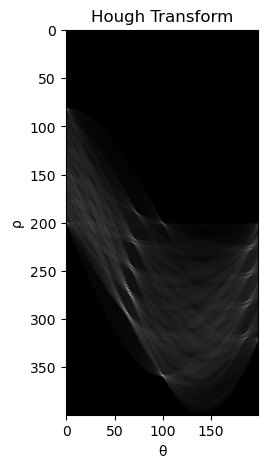

In [5]:
#find the hough accumulator,rhoRange, and thetaRange 
H, rhoRange, thetaRange = HoughTransform(threshold_img,200,100)
plt.figure(figsize=(5, 5))
plt.imshow(H, cmap='gray')
plt.xlabel('θ')
plt.ylabel('ρ')
plt.title('Hough Transform')

### Finding Lines

In [6]:

def nonmax_suppression(H):
    
    #suppress nearest neigbours
    H_suppressed = np.zeros(H.shape)
    
    #loop through the pixels in H and suppress if not local maxima
    for i in range(1, H.shape[0] - 1):
        for j in range(1, H.shape[1] - 1):
            
            neigh = H[i-1:i+2, j-1:j+2]
            
            if H[i, j] == np.max(neigh):
                H_suppressed[i, j] = H[i, j]
                
    return H_suppressed
    
#find the maximum rhos and thetas with highest vote in accumulator     
def HoughLines(H, nLines, rhoRange, thetaRange):
    
    #do non maxima suppression
    H = nonmax_suppression(H)
    
    rhos = np.zeros(nLines)
    thetas = np.zeros(nLines)

    for i in range(nLines):
        #find the index of maxima and find the corresponding theta and rho index
        max_index = np.argmax(H)
        rho_index, theta_index = np.unravel_index(max_index, H.shape)
        
        #find and return the rho and theta values 
        rhos[i] = rhoRange[rho_index]
        thetas[i] = thetaRange[theta_index]
        
        #set the picked H pixel to 0
        H[rho_index,theta_index]=0
        
    return(rhos,thetas)

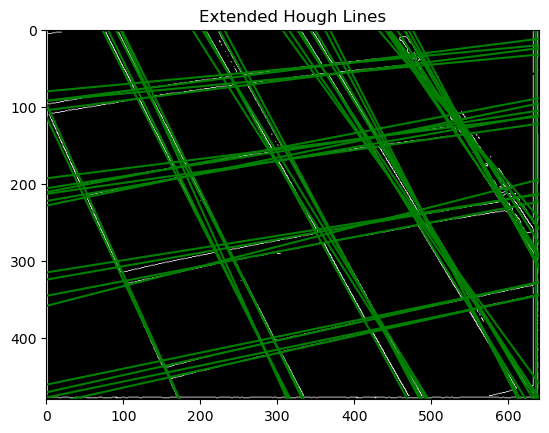

In [7]:
rhos,thetas = HoughLines(H, 50, rhoRange, thetaRange)

#display the lines ontop of edge image
def drawing_lines(im,rhos,thetas):
    plt.imshow(im, cmap='gray')

    for i in range(len(rhos)):
        
        rho = rhos[i]
        theta = thetas[i]
        
        #find the point on the line
        x0 = rho*np.cos(theta)
        y0 = rho*np.sin(theta)

        #extend the point
        x1 = int(x0 + 1000 * (-np.sin(theta)))
        y1 = int(y0 + 1000 * (np.cos(theta)))
        x2 = int(x0 - 1000 * (-np.sin(theta)))
        y2 = int(y0 - 1000 * (np.cos(theta))) 
  
        #plot the start and end points
        plt.plot([x1, x2], [y1, y2], 'green')
    
    #limit the plot since lines are extended
    plt.xlim([0, im.shape[1]])
    plt.ylim([im.shape[0], 0])
    plt.title('Extended Hough Lines')
    plt.show()

#draw the nLines
drawing_lines(threshold_img,rhos,thetas)


### Fitting line segments

In [8]:
def HoughLineSegments(Im,rhos,thetas):
    
    #take height and width of edge image and initialize start and end points list
    height, width = Im.shape 
    start_points=[]
    end_points=[]
    
    for i in range(len(rhos)):
        
        #loop through each rho and theta 
        start_detect = False
        rho = rhos[i]
        theta = thetas[i]
        
        #to take care of rare cases when the end point of a line is start_point
        last_point = None 
        
        for x in range (width):
            #find the corresponding y based on rho,theta, and x, and restrict to image bound
            y = round((rho - x*np.cos(theta))/(np.sin(theta))+0.0000001)
            
            if(y>=0 and y<height):
               
                #if the line point is an edge and start point not yet detected, append start point
                #and change bool to True
                if (Im[y,x] != 0): 
                    if( not(start_detect) ):
                        start_points.append((x,y))
                        start_detect = True
                    
                    #set last_point to edge point
                    last_point = (x, y)
                    
                #if line point is not an edge and start point already detected, set end point 
                #to last edge point and change bool to false
                elif( Im[y,x] == 0  and start_detect):
                    end_points.append(last_point)
                    start_detect = False
                    
                    
    
        #if last point of the line is edge point and end point not yet found, make that an end point
        if(start_detect):
            end_points.append(last_point)
        
    return(start_points,end_points) 
    


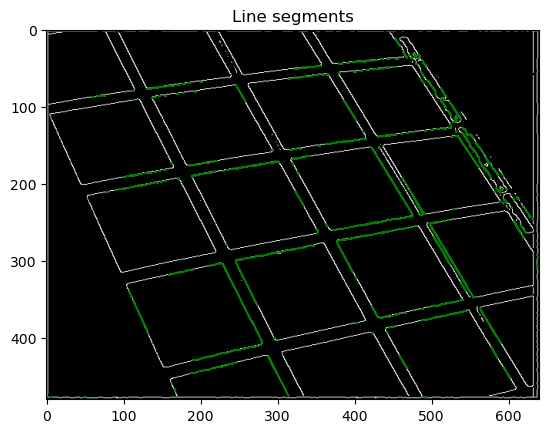

In [9]:
#find start and end points and draw line segments
start_points,end_points = HoughLineSegments(threshold_img,rhos,thetas)

def drawing_segments(im,starts,ends):
    #plot original edge image
    plt.imshow(im, cmap='gray')
    
    #plot points
    for i in range(len(starts)):
        plt.plot([starts[i][0],ends[i][0]], [starts[i][1], ends[i][1]], 'green')
   
    plt.title('Line segments')
    plt.show()

drawing_segments(threshold_img,start_points,end_points)


### Test and verify

Text(0.5, 1.0, 'P = 10% Threshold image')

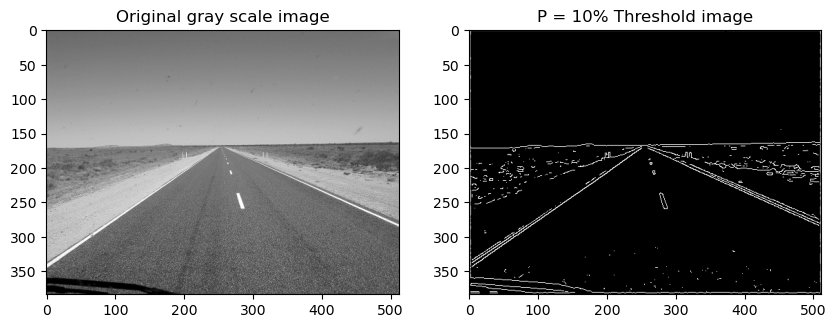

In [10]:
#test for another image

#until ptile section
test_img2 = cv2.imread('img04.jpg')
test_img2 = cv2.cvtColor(src=test_img2, code=cv2.COLOR_BGR2GRAY)
gauss_output2 = gauss_smoothing(test_img2)
gradient_output2, gradient_angle2, gradient_x2, gradient_y2 = gradient_operation(gauss_output2)
nonmax_suppress_img2 = non_maxima_suppression(gradient_output2, gradient_angle2)
#use threshold of 10
threshold_img2,threshold_value2,num_edges2 = ptile_thresholding(nonmax_suppress_img2,10)

#plot original gray image and final edge image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  
plt.imshow(test_img2, cmap='gray')
plt.title('Original gray scale image')
plt.subplot(1, 2, 2) 
plt.imshow(threshold_img2, cmap='gray')
plt.title('P = 10% Threshold image')


Text(0.5, 1.0, 'Hough Transform')

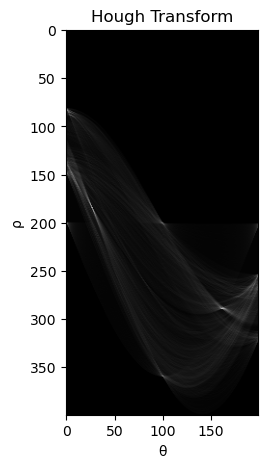

In [11]:
#find and plot hough accumulator
H, rhoRange, thetaRange = HoughTransform(threshold_img2,200,100)
plt.figure(figsize=(5, 5))
plt.imshow(H, cmap='gray')
plt.xlabel('θ')
plt.ylabel('ρ')
plt.title('Hough Transform')



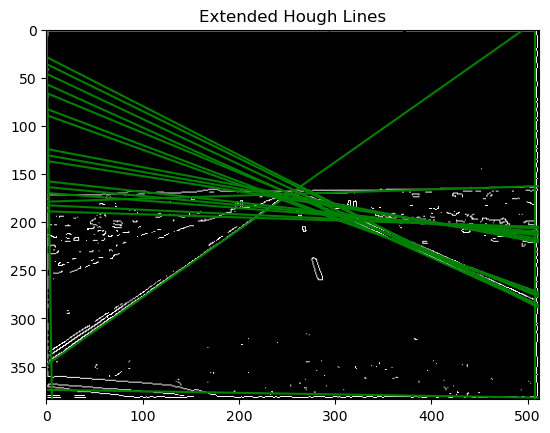

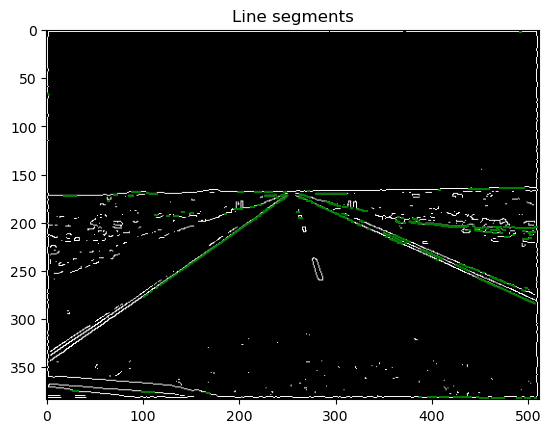

In [12]:
#find rhos thetas, start and end points 
rhos,thetas = HoughLines(H, 20, rhoRange, thetaRange)
start_points,end_points = HoughLineSegments(threshold_img2,rhos,thetas)

#plot line
drawing_lines(threshold_img2,rhos,thetas)

#plot line segments
drawing_segments(threshold_img2,start_points,end_points)


After trying the hough line segments detection using different images, the effect of some parameters can be observed. First, is the p threshold value. For some images, like the initial one in this lab, a higher p threshold value is preferable to detect the edges, but for others like the second one a low value is preferred since a higher would result in noise (detecting tiny edges). The other parameter is the resolution where a higher resolution (number of rhos and theta elements) is better for larger images. The number of lines (rhos and thetas chosen as the maximum from the hough accumulator) can also have an effect, where as for some like the second one, a fewer number of lines is enough to detect the major line segments, while for the first one a relatively higher number of lines is better since there are smaller lines due to the squares and to create continued line segments a higher number of lines is better. 